# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os

# Disable scientific notation
np.set_printoptions(suppress=True)

# Read Image

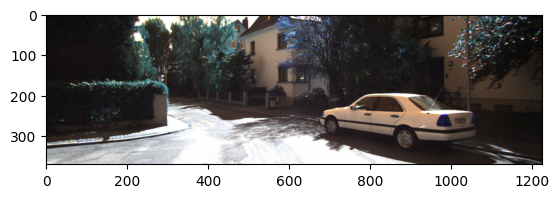

In [26]:
image = cv2.imread('L.png')
#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)
width, height = image.shape[1], image.shape[0]

# Load Matrices

In [4]:
velo_2_cam = open("calib_velo_to_cam.txt", "r")
cam_2_cam = open('calib_cam_to_cam.txt','r')

lines = velo_2_cam.readlines()
lines2 = cam_2_cam.readlines()

data_r = np.array(lines[1][3:-1].split(),dtype=np.float32).reshape(3,3)
data_t = np.array(lines[2][3:-1].split(),dtype=np.float32).reshape(3,1)

intrinsic_matrix = np.array(lines2[19][5:-1].split(),dtype = np.float32).reshape(3,3)
extrinsic_matrix = np.hstack((data_r, data_t))
rectification_matrix = np.array(lines2[24][11:-1].split(),dtype = np.float32).reshape(3,3)
projection_matrix = np.array(lines2[25][11:-1].split(),dtype = np.float32).reshape(-1,4)


# Create dataframe of lidar points 

In [14]:
raw_pts = np.fromfile('lidar_points.bin', dtype=np.float32).reshape(-1,4)
points = pd.DataFrame(raw_pts,columns=['X','Y','Z','I'])
points = points[points['X'] > 0]

# Apply fusion algorithm

In [143]:
image = cv2.imread('L.png')
print(image.shape)
pixel_points = []
lidar_points = []
for i in range(len(points)):
    x, y, z = points.iloc[i,:3]
    depth = math.sqrt(x**2 + y**2 + z**2)
    if 0 < depth < 25 :
        color = (0,0,255)
    elif 25 <= depth <= 50 :
        color = (0,255,0) 
    else :
        color = (255,0,0)
    world_pt = np.array([x,y,z]).T 
    pt_cam_coordinate = np.dot(data_r, world_pt) + data_t.T.flatten() 
    rectified_pt = np.dot(rectification_matrix,pt_cam_coordinate)
    rectified_pt = np.hstack((rectified_pt, [1]))
    projected_pt = np.dot(projection_matrix, rectified_pt)
    #print(projected_pt)
    u , v  = int(projected_pt[0] / projected_pt[2]), int(projected_pt[1] / projected_pt[2])
    if 0 < u < 1226 :
        if 0 < v < 370 :
            pixel_points.append((u,v))
            lidar_points.append((u,v,int(depth)))

            cv2.circle(image,(u,v),1,color)
    
x_pts = [x[0] for x in pixel_points]
y_pts = [x[1] for x in pixel_points]


(370, 1226, 3)


In [153]:
lidar_points
filtered_lidar_points_np = []
for x,y,z in lidar_points:
    filtered_lidar_points_np.append((y,x,z))


# View Result

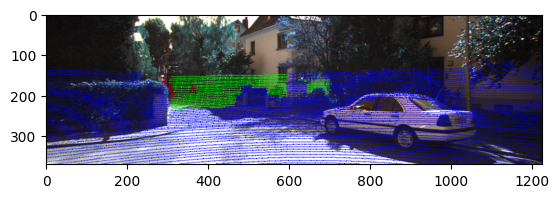

In [146]:
plt.imshow(image)

In [25]:
cv2.imwrite('correct_fused_image.png',image)

True

In [10]:
import numpy as np
import open3d as o3d

# Load point cloud from .bin file
def load_point_cloud(bin_path):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)  # (x,y,z,intensity)
    return points[:, :3]

# Your point cloud path
bin_path = 'lidar_points.bin'
points = load_point_cloud(bin_path)

# Create Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Optionally colorize points based on height (Z-axis)
colors = np.zeros_like(points)
colors[:, 2] = (points[:, 2] - points[:, 2].min()) / np.ptp(points[:, 2])

pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize in 3D viewer
o3d.visualization.draw_geometries([pcd])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Create dense map

In [95]:
def normalize(list1, min_bound, max_bound):
    '''Normalizes an input lists and returns  list with normalized values'''

    normalized_list = []
    min_value = min(list1)
    difference = max(list1) - min(list1)
    
    for x in list1:
        normalized_value = min_bound +  ((x - min_value) / difference) * (max_bound - min_bound)
        normalized_list.append(int(normalized_value))

    return normalized_list
    

In [123]:
depths = [c for (a,b,c) in filtered_lidar_points]
depths_normalized = normalize(depths,0,255)
filtered_lidar_points_np[i][0:2]

(146, 604)

In [125]:
depths_np = []
for i in range(len(filtered_lidar_points_np)):
    a , b = filtered_lidar_points_np[i][0:2]
    c = depths_normalized[i]
    depths_np.append((a,b,c))

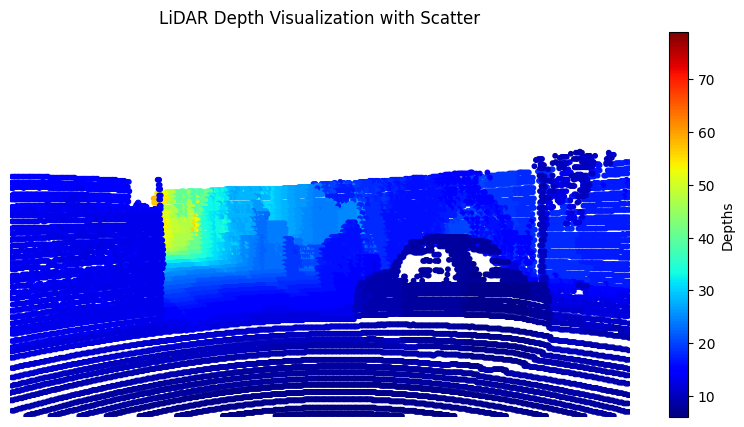

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# Define image size (replace with actual image dimensions)

# Convert list to NumPy array
filtered_lidar_points_np = np.array(depths_np)

# Extract pixel coordinates (x, y) and depth values
x_coords = filtered_lidar_points_np[:, 0]
y_coords = filtered_lidar_points_np[:, 1]
depth_values = filtered_lidar_points_np[:, 2]

# Normalize depth values to range [0, 1] for colormap
min_depth, max_depth = np.min(depth_values), np.max(depth_values)
if max_depth > min_depth:
    normalized_depths =(0 + ((depth_values - min_depth) / (max_depth - min_depth)) * (255))
else:
    normalized_depths = np.zeros_like(depth_values)  # Avoid division by zero

# Create scatter plot on a black background
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor('black')  # Set black background

# Plot LiDAR points using scatter (color-coded by depth)
plt.scatter(y_coords, x_coords, c=depths, cmap='jet', s=10, alpha=1.0)

# Adjust plot settings
plt.colorbar(label="Depths")
plt.title("LiDAR Depth Visualization with Scatter")
plt.xlim(0, width)   # Set x-axis limits
plt.ylim(height, 0)  # Flip y-axis to match image coordinates
plt.axis('off')      # Hide axes for a clean image
plt.savefig('Lidar.png')
plt.show()
